In [1]:
%env PATH=/usr/local/cuda-11.8/bin:$PATH
%env LD_LIBRARY_PATH=/usr/local/cuda-11.8/lib64:$LD_LIBRARY_PATH

env: PATH=/usr/local/cuda-11.8/bin:$PATH
env: LD_LIBRARY_PATH=/usr/local/cuda-11.8/lib64:$LD_LIBRARY_PATH


In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from model import MNISTDiffusion
from utils import ExponentialMovingAverage
import os
import math
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/conda/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda9SetDeviceEi'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.backends.cudnn.version())

2.0.0+cu117
True
11.7
8900


In [4]:
use_cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
batch_size = 128
epochs = 50
lr = 0.001
n_samples = 36
model_base_dim = 64
model_ema_steps = 10
model_ema_decay = 0.995
log_freq = 10
no_clip = True
timesteps = 1000

cuda


In [5]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

In [6]:
model = MNISTDiffusion(timesteps=timesteps,
            image_size=28,
            in_channels=1,
            base_dim=model_base_dim,
            dim_mults=[2,4]).to(device)

In [7]:
#torchvision ema setting
#https://github.com/pytorch/vision/blob/main/references/classification/train.py#L317
adjust = 1 * batch_size * model_ema_steps / epochs
alpha = 1.0 - model_ema_decay
alpha = min(1.0, alpha * adjust)
model_ema = ExponentialMovingAverage(model, device=device, decay=1.0 - alpha)

In [8]:
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = OneCycleLR(optimizer, lr, total_steps=epochs*len(train_loader), pct_start=0.25, anneal_strategy='cos')
loss_fn = nn.MSELoss(reduction='mean')

# Train

In [ ]:
global_steps=0
for i in range(epochs):
    model.train()
    for j, (image,target) in enumerate(train_loader):
        noise=torch.randn_like(image).to(device)
        image=image.to(device)
        pred=model(image,noise)
        loss=loss_fn(pred,noise)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
        
        if global_steps % model_ema_steps==0:
            model_ema.update_parameters(model)
            
        global_steps+=1
        if j % log_freq==0:
            print("Epoch[{}/{}],Step[{}/{}],loss:{:.5f},lr:{:.5f}".format(i+1,epochs,j,len(train_loader),
                                                                loss.detach().cpu().item(), scheduler.get_last_lr()[0]))
    ckpt={"model":model.state_dict(),
            "model_ema":model_ema.state_dict()}

Epoch[1/50],Step[0/469],loss:1.09009,lr:0.00004
Epoch[1/50],Step[10/469],loss:1.08048,lr:0.00004
Epoch[1/50],Step[20/469],loss:1.07641,lr:0.00004
Epoch[1/50],Step[30/469],loss:1.05467,lr:0.00004
Epoch[1/50],Step[40/469],loss:1.05302,lr:0.00004
Epoch[1/50],Step[50/469],loss:1.02919,lr:0.00004
Epoch[1/50],Step[60/469],loss:1.01602,lr:0.00004
Epoch[1/50],Step[70/469],loss:1.00828,lr:0.00004
Epoch[1/50],Step[80/469],loss:1.00044,lr:0.00004
Epoch[1/50],Step[90/469],loss:0.98512,lr:0.00004
Epoch[1/50],Step[100/469],loss:0.98650,lr:0.00004
Epoch[1/50],Step[110/469],loss:0.96665,lr:0.00004
Epoch[1/50],Step[120/469],loss:0.95398,lr:0.00004
Epoch[1/50],Step[130/469],loss:0.93260,lr:0.00004
Epoch[1/50],Step[140/469],loss:0.90248,lr:0.00004
Epoch[1/50],Step[150/469],loss:0.89873,lr:0.00004
Epoch[1/50],Step[160/469],loss:0.87806,lr:0.00004
Epoch[1/50],Step[170/469],loss:0.85202,lr:0.00004
Epoch[1/50],Step[180/469],loss:0.84633,lr:0.00004
Epoch[1/50],Step[190/469],loss:0.80574,lr:0.00004
Epoch[1/50]

# Reconstruct

In [ ]:
torch.save(model.state_dict(), './model.torch')
torch.save(model_ema.state_dict(), './model_ema.torch')

In [12]:
model.load_state_dict(torch.load('./model.torch'))
model_ema.load_state_dict(torch.load('./model_ema.torch'))

<All keys matched successfully>

In [13]:
samples=model_ema.module.sampling(n_samples, clipped_reverse_diffusion=not no_clip, device=device)

Sampling: 100%|██████████| 1000/1000 [00:29<00:00, 34.11it/s]


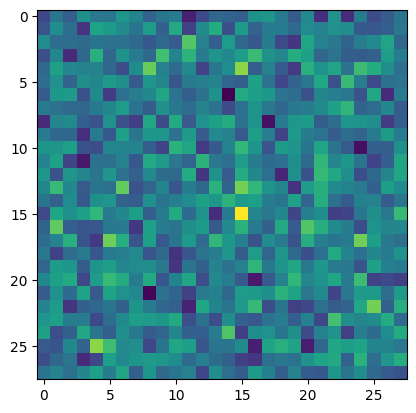

In [17]:
import matplotlib.pyplot as plt
plt.imshow(samples[0,0].detach().cpu().numpy())

In [39]:
save_image(samples,"results/steps_{:0>8}.png".format(global_steps),nrow=int(math.sqrt(n_samples)))